In [1]:
import os
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:



#TRAIN_SIZE = int(TOTSAMPLE*0.8)
#TRAIN_SIZE = 5462
TRAIN_SIZE = 8000
#EVAL_SIZE = 395 #Use when non-ag included (does not include slope)
#EVAL_SIZE = TOTSAMPLE - TRAIN_SIZE
#EVAL_SIZE = 523
EVAL_SIZE = 2000

# Specify model training parameters.
BATCH_SIZE = 32
EPOCHS = 1000 #Should auto-stop
BUFFER_SIZE = TRAIN_SIZE+BATCH_SIZE


YEARS_PYTHON = ['2005', '2016']
FOLIUMLOCATION = [39.811,-111.625,]

ALL_BANDS = [f'BGR{i}_median' for i in range(3)]+[f'SWIR{i}_median' for i in range(3)]+[f'SR_TH_median']+\
                [f'BGR{i}_diff' for i in range(3)]+[f'SWIR{i}_diff' for i in range(3)]+[f'SR_TH_diff']+\
                [f'BGR{i}_stdDev' for i in range(3)]+[f'SWIR{i}_stdDev' for i in range(3)]+[f'SR_TH_stdDev']


import re
BANDS_TO_USE = ALL_BANDS
        
#RESPONSE = ['Drip', 'Dry Crop', 'Flood', 'Sprinkler'] #Use if drip is to be trained for
#RESPONSE = ['Dry Crop', 'Flood', 'Sprinkler'] 
#RESPONSE = ['Flood', 'Sprinkler'] 
#RESPONSE =['Irrigation']
RESPONSE = ['flood', 'sprinkler', 'other']
#RESPONSE_TO_USE = ['sprinkler']
RESPONSE_TO_USE = RESPONSE

ALL_FEATURES = ALL_BANDS+RESPONSE
FEATURES_TO_USE = BANDS_TO_USE+RESPONSE_TO_USE

if len(RESPONSE_TO_USE) >1:
    OPTIMIZER = 'Adam'
    LOSS = 'categorical_crossentropy'
    #METRICS = ['RootMeanSquaredError']
    METRICS = ['RootMeanSquaredError', 'categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    ACTIVATION = 'softmax'
else:
    OPTIMIZER = 'Adam'
    LOSS = 'binary_crossentropy'
    #METRICS = ['RootMeanSquaredError']
    METRICS = ['RootMeanSquaredError', 'binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    ACTIVATION = 'sigmoid'


# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 64
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in ALL_FEATURES
]
COLUMNS2 = [
  tf.io.FixedLenFeature([], tf.string) for k in ALL_FEATURES
]
ALL_FEATURES_DICT = dict(zip(ALL_FEATURES, COLUMNS))
ALL_FEATURES_DICT_STRING = dict(zip(ALL_FEATURES, COLUMNS2))



# Specify names locations for outputs in Cloud Storage. 
#FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL'
#FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_NoNormalization'
#FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized'
#FOLDER = '/' + 'project/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_l8_9_22_22'
#FOLDER = '/' + 'project/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_l8_9_22_22'
#FOLDER = '/' + 'project/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_l5_9_26_22'
FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_lib7_4_l8l5_avg'
TRAINING_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_train'
EVAL_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_eval'






# Training data

Load the data exported from Earth Engine into a `tf.data.Dataset`.  The following are helper functions for that.

In [3]:
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  example_message = tf.io.parse_single_example(example_proto, ALL_FEATURES_DICT_STRING)
  features = {}
  for feature_name in example_message:
    thisfeature = example_message[feature_name]
    features[feature_name] = tf.io.parse_tensor(thisfeature, out_type=tf.float32)
        
  return features

def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES_TO_USE]
  #inputsList = normalize_inputs(inputs)
  
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS_TO_USE)], stacked[:,:,len(BANDS_TO_USE):]

def sample_to_dict(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = {key:inputs.get(key) for key in FEATURES_TO_USE}
    return inputsList



In [4]:
YEARS = []

MINYEAR = 2003
MAXYEAR = 2022
    
    
for year in range(MINYEAR,MAXYEAR):
    if year not in [2012,2016,2017]:
        YEARS.append(year)


In [5]:

def do_not_augment_data(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]    
    


def get_dataset(fname_):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    dataset = tf.data.TFRecordDataset(fname_)
    dataset = dataset.map(parse_tfrecord)
    dataset = dataset.map(sample_to_dict)
    return dataset


# Use the helpers to read in the training dataset.  Print the first record to check.

# In[36]:

def get_year_data_T(fname_):
    
    dataset = get_dataset(fname_)
    dataset = dataset.take(-1)
    return dataset

def get_year_data_E(fname_):
    
    dataset = get_dataset(fname_)
    dataset = dataset.take(-1)
    return dataset

    

In [6]:
SAMPLES_PER_YEAR = 200    
YEARS = []

MINYEAR = 2003
MAXYEAR = 2022
    
    
for year in range(MINYEAR,MAXYEAR):
    if year not in [2012,2016,2017]:
        YEARS.append(year)

NYEARS = len(YEARS)


import json
Nsamples = {}
with open(os.path.join(FOLDER, 'NSamples.json'), 'r') as fh:
    Nsamples = json.load(fh)

print(f'Samples per year: {Nsamples}')
sampl_tot = {'Training':0,'Evaluation':0}
for spl in Nsamples['Training']:
    sampl_tot['Training'] += Nsamples['Training'][spl]
    sampl_tot['Evaluation'] += Nsamples['Evaluation'][spl]
NWEIGHTS = {'Training':{}, 'Evaluation':{}}
for spl in Nsamples['Training']:
    NWEIGHTS['Training'][int(spl)] = min(SAMPLES_PER_YEAR/Nsamples['Training'][spl], 1.0)
    NWEIGHTS['Evaluation'][int(spl)] = min((SAMPLES_PER_YEAR/4)/Nsamples['Evaluation'][spl], 1.0)


Samples per year: {'Training': {'2003': 882, '2004': 565, '2005': 321, '2006': 582, '2007': 383, '2008': 243, '2009': 657, '2010': 506, '2011': 345, '2013': 196, '2014': 210, '2015': 659, '2018': 754, '2019': 763, '2020': 729, '2021': 738}, 'Evaluation': {'2003': 231, '2004': 140, '2005': 67, '2006': 142, '2007': 98, '2008': 55, '2009': 179, '2010': 124, '2011': 85, '2013': 48, '2014': 48, '2015': 177, '2018': 191, '2019': 186, '2020': 189, '2021': 189}}


Use the helpers to read in the training dataset.  Print the first record to check.

In [7]:
def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    fnames_ = [f'{FOLDER}/Proc_Samples_{year}_{TRAINING_BASE}.tfrecords' for year in YEARS]
    weights = [NWEIGHTS['Training'][year] for year in YEARS]
    datasets = [get_year_data_T(fname) for fname in fnames_]
    dataset = tf.data.experimental.sample_from_datasets(datasets, weights = weights)
    dataset = dataset.take(int(SAMPLES_PER_YEAR*NYEARS)).cache()
    dataset = dataset.map(do_not_augment_data)
    dataset = dataset.batch(1)
    return dataset

training = get_training_dataset()

#print(iter(training.take(1)).next())

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


# Evaluation data

Now do the same thing to get an evaluation dataset.  Note that unlike the training dataset, the evaluation dataset has a batch size of 1, is not repeated and is not shuffled.

In [8]:
def get_eval_dataset():
    """Get the preprocessed evaluation dataset
    Returns: 
    A tf.data.Dataset of evaluation data.
    """
    fnames_ = [f'{FOLDER}/Proc_Samples_{year}_{EVAL_BASE}.tfrecords' for year in YEARS]
    weights = [NWEIGHTS['Evaluation'][year] for year in YEARS]
    datasets = [get_year_data_T(fname) for fname in fnames_]
    dataset = tf.data.experimental.sample_from_datasets(datasets, weights = weights)
    dataset = dataset.take(int(SAMPLES_PER_YEAR*NYEARS/4)).cache()
    dataset = dataset.map(do_not_augment_data)
    dataset = dataset.batch(1)
    return dataset

evaluation = get_eval_dataset()

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

CONVSIZE=3
DROPOUT = 0.1
BNTF = True
def conv_block(input_tensor, num_filters, bnlast=False):
    encoder = layers.Conv2D(num_filters, (CONVSIZE, CONVSIZE), padding='same')(input_tensor)
    if bnlast:
        encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Dropout(DROPOUT)(encoder)
    
    encoder = layers.Conv2D(num_filters, (CONVSIZE, CONVSIZE), padding='same')(encoder)
    
    if bnlast:
        encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Dropout(DROPOUT)(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters, BNTF)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    if BNTF:
        decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Dropout(DROPOUT)(decoder)
    decoder = conv_block(decoder, num_filters, BNTF)
    return decoder


def get_model_simple(n_neurons = 32):
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64
    encoder0_pool, encoder0 = encoder_block(inputs, n_neurons) # 128  #32
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, n_neurons*2) # 64  #16
    center = conv_block(encoder1_pool, n_neurons*4) # center
    decoder1 = decoder_block(center, encoder1, n_neurons*2) # 32
    decoder0 = decoder_block(decoder1, encoder0, n_neurons) # 64
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

def get_model_64(n_neurons = 32):
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64
    encoder0_pool, encoder0 = encoder_block(inputs, n_neurons) # 128  #32 
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, n_neurons*2) # 64  #16
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, n_neurons*4) # 32 # 8
    
    center = conv_block(encoder2_pool, n_neurons*8) # center
    
    decoder2 = decoder_block(center, encoder2, n_neurons*4) # 64 #16
    decoder1 = decoder_block(decoder2, encoder1, n_neurons*2) # 128 #32
    decoder0 = decoder_block(decoder1, encoder0, n_neurons) # 256 #64
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

def get_model_64_2(n_neurons = 8):
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64
    encoder0_pool, encoder0 = encoder_block(inputs, n_neurons) # 128  #32 
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, n_neurons*2) # 64  #16
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, n_neurons*4) # 32 # 8
    
    center = conv_block(encoder2_pool, n_neurons*8) # center
    
    decoder2 = decoder_block(center, encoder2, n_neurons*4) # 64 #16
    decoder1 = decoder_block(decoder2, encoder1, n_neurons*2) # 128 #32
    decoder0 = decoder_block(decoder1, encoder0, n_neurons) # 256 #64
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

def get_model_64_BN(n_neurons = 32):
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64
    inputs_BN = layers.BatchNormalization()(inputs)
    encoder0_pool, encoder0 = encoder_block(inputs_BN, n_neurons) # 128  #32 
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, n_neurons*2) # 64  #16
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, n_neurons*4) # 32 # 8
    
    center = conv_block(encoder2_pool, n_neurons*8) # center
    
    decoder2 = decoder_block(center, encoder2, n_neurons*4) # 64 #16
    decoder1 = decoder_block(decoder2, encoder1, n_neurons*2) # 128 #32
    decoder0 = decoder_block(decoder1, encoder0, n_neurons) # 256 #64
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

def get_model_deeper(n_neurons = 32):
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64 #32
    #inputsG = layers.GaussianNoise(0.002)(inputs)
    #inputsN = layers.LayerNormalization(axis = -1)(inputsG)
    #inputsN = layers.BatchNormalization()(inputsG)
    encoder0_pool, encoder0 = encoder_block(inputs, n_neurons) # 128  #32
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, n_neurons*2) # 64  #16
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, n_neurons*4) # 32 # 8
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, n_neurons*8) # 16 # 4  
    
    center = conv_block(encoder3_pool, n_neurons*16) # center #2
    
    decoder3 = decoder_block(center, encoder3, n_neurons*8) # 4
    decoder2 = decoder_block(decoder3, encoder2, n_neurons*4) # 8
    decoder1 = decoder_block(decoder2, encoder1, n_neurons*2) # 16
    decoder0 = decoder_block(decoder1, encoder0, n_neurons) # 32
    #decoder0 = layers.BatchNormalization()(decoder0)
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0) #64

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

def get_model_deeper_1BN(n_neurons = 32):
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64 #32
    encoder0_pool, encoder0 = encoder_block(inputs, n_neurons) # 128  #32
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, n_neurons*2) # 64  #16
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, n_neurons*4) # 32 # 8
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, n_neurons*8) # 16 # 4  
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, n_neurons*16) # 16 # 4  
    
    center = conv_block(encoder4_pool, n_neurons*32) # center #2
    
    decoder4 = decoder_block(center, encoder4, n_neurons*16) # 4
    decoder3 = decoder_block(decoder4, encoder3, n_neurons*8) # 4
    decoder2 = decoder_block(decoder3, encoder2, n_neurons*4) # 8
    decoder1 = decoder_block(decoder2, encoder1, n_neurons*2) # 16
    decoder0 = decoder_block(decoder1, encoder0, n_neurons) # 32
    decoder0 = layers.BatchNormalization()(decoder0)
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0) #64

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

def get_model_deeperN(n_neurons = 32):
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64 #32
    inputsN = layers.LayerNormalization(axis = -1)(inputs)
    encoder0_pool, encoder0 = encoder_block(inputsN, n_neurons) # 128  #32
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, n_neurons*2) # 64  #16
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, n_neurons*4) # 32 # 8
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, n_neurons*8) # 16 # 4  
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, n_neurons*16) # 16 # 4  
    
    center = conv_block(encoder4_pool, n_neurons*32) # center #2
    
    decoder4 = decoder_block(center, encoder4, n_neurons*16) # 4
    decoder3 = decoder_block(decoder4, encoder3, n_neurons*8) # 4
    decoder2 = decoder_block(decoder3, encoder2, n_neurons*4) # 8
    decoder1 = decoder_block(decoder2, encoder1, n_neurons*2) # 16
    decoder0 = decoder_block(decoder1, encoder0, n_neurons) # 32
    
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0) #64

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

def get_model_deeper_BN(n_neurons = 32):
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64 #32
    inputs_BN = layers.BatchNormalization()(inputs)
    encoder0_pool, encoder0 = encoder_block(inputs_BN, n_neurons) # 128  #32
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, n_neurons*2) # 64  #16
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, n_neurons*4) # 32 # 8
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, n_neurons*8) # 16 # 4  
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, n_neurons*16) # 16 # 4  
    
    center = conv_block(encoder4_pool, n_neurons*32) # center #2
    
    decoder4 = decoder_block(center, encoder4, n_neurons*16) # 4
    decoder3 = decoder_block(decoder4, encoder3, n_neurons*8) # 4
    decoder2 = decoder_block(decoder3, encoder2, n_neurons*4) # 8
    decoder1 = decoder_block(decoder2, encoder1, n_neurons*2) # 16
    decoder0 = decoder_block(decoder1, encoder0, n_neurons) # 32
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0) #64

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

def get_model_32():
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64 #32
    encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128  #32 #16
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64  #16 #8
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32 # 8 #4
    
    center = conv_block(encoder2_pool, 256) # center
    
    decoder2 = decoder_block(center, encoder2, 128) # 32 # 8 #4
    decoder1 = decoder_block(decoder2, encoder1, 64) # 64  #16 #8
    decoder0 = decoder_block(decoder1, encoder0, 32)  # 128  #32 #16
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model


def print_params(model):
    total_params = 0 # initialize counter for total params
    trainable_params = 0 # initialize counter for trainable params
    print('Layer Name\t\tType\t\tFilter shape\t\t# Parameters\tTrainable') # print column headings
    for layer in model.layers: # loop over layers
        lname = layer.name # grab layer name
        ltype = type(layer).__name__ # grab layer type
        ltype[ltype.find('/'):] # parse for only the last part of the string
        if ltype=='Conv2D': # print for convolutional layers
            weights = layer.get_weights()
            print(lname+'\t\t'+ltype+'\t\t'+str(weights[0].shape)+'\t\t'+\
                  str(layer.count_params())+'\t'+str(layer.trainable))
            if layer.trainable:
                trainable_params += layer.count_params()
            total_params += layer.count_params() # update number of params
        elif ltype=='MaxPooling2D': # print for max pool layers
            weights = layer.get_weights()
            print(lname+'\t\t'+ltype+'\t---------------\t\t---')
        elif ltype=='Flatten': # print for flatten layers
            print(lname+'\t\t'+ltype+'\t\t---------------\t\t---')
        elif ltype=='Dense': # print for dense layers
            weights = layer.get_weights()
            print(lname+'\t\t\t'+ltype+'\t\t'+str(weights[0].shape)+'\t\t'+\
                  str(layer.count_params())+'\t'+str(layer.trainable))
            if layer.trainable:
                trainable_params += layer.count_params()
            total_params += layer.count_params() # update number of params
    print('---------------')
    print('Total trainable parameters: '+str(trainable_params)) # print total params
    print('Total untrainable parameters: '+str(total_params-trainable_params))
    print('Total parameters: '+str(total_params))

# Evaluating the model
Load the weights from saved model

In [61]:
from keras.models import load_model



MODELFOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/' + 'Irrigation_detection' + '/' \
+ 'Irrigation_detection_lib7_4_l8l5_avg/'

#MODELNAME='Model_Irrig_detection_binary_WRLU_31_bands_NoCDL_64x64_2022_08_28_21_42_64_BN_500' #Best saved to Check_on_TFCC/Best
#MODELNAME='Model_Irrig_detection_binary_WRLU_30_bands_NoCDL_64x64_CONVSIZE3_2022_09_17_04_54_64_0'
#MODELNAME='Balanced_Model_Irrig_detection_multiclass_WRLU_9_bands_NoCDL_64x64_CONVSIZE5_2022_11_03_16_21_deeper_200_DNoRegu' #Good
#MODELNAME='Balanced_Model_Irrig_detection_multiclass_WRLU_42_bands_NoCDL_64x64_CONVSIZE3_2022_11_18_20_06_deeper_BN_100_DNoRegu_Normalized'###Worked OK for TFCC and Utah, just that some years are not good
MODELNAME='Balanced_Model_Irrig_detection_multiclass_WRLU_21_bands_NoCDL_64x64_CONVSIZE3_2023_01_27_15_25_64_20_DNoRegu'
ENSEMBLENAME = 'Balanced_Model_Irrig_detection_multiclass_WRLU_21_bands_NoCDL_64x64_CONVSIZE3_20'+'_ensemble'

#del m
#m = get_model()
#m = get_model_deeper(n_neurons = 64)
#m = get_model_64(n_neurons = 64)

#m = get_model_deeper_BN(n_neurons = 32)
#m = get_model_deeper_BN(n_neurons = 64)


#m = get_model_evendeeper(n_neurons = 32)
#m = get_model_64_BN(n_neurons = 64)
#m = get_model_64_2(n_neurons = 16)
#m = get_model_simple(n_neurons = 32)
#m.load_weights(os.path.join(MODELFOLDER, MODELNAME+'.h5'))

m = load_model(os.path.join(FOLDER, ENSEMBLENAME+'.h5'))
#print_params(m)
#print(m.summary())



In [62]:
#performance = m.evaluate(evaluation)


In [63]:
predicted_eval = m.predict(evaluation)

In [64]:
import numpy as np
performance_data = {'obs':np.array([], dtype = np.int8), 'pred':np.array([], dtype = np.int8)}
cnt = 0
for eval_batch in evaluation:
    for eval_sample in eval_batch[1]:
        eval_sample_np = eval_sample.numpy()
        #print(eval_sample_np.shape)
        if len(RESPONSE_TO_USE) > 1:
            yobs = np.argmax(eval_sample_np, axis = 2).flatten()
            ypred = np.argmax(predicted_eval[cnt], axis = 2).flatten()
            performance_data['obs'] = np.concatenate((yobs, performance_data['obs']))
            performance_data['pred'] = np.concatenate((ypred, performance_data['pred']))
        else:
            yobs = eval_sample_np.flatten()
            ypred = predicted_eval[cnt] >= 0.5
            ypred = ypred.flatten()
            performance_data['obs'] = np.concatenate((yobs, performance_data['obs']))
            performance_data['pred'] = np.concatenate((ypred, performance_data['pred']))
        cnt += 1
        
        
    

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(performance_data['obs'], performance_data['pred']))
print(classification_report(performance_data['obs'], performance_data['pred']))


[[756963 116779 167775]
 [171175 762214 123148]
 [126549  55186 997011]]
              precision    recall  f1-score   support

           0       0.72      0.73      0.72   1041517
           1       0.82      0.72      0.77   1056537
           2       0.77      0.85      0.81   1178746

    accuracy                           0.77   3276800
   macro avg       0.77      0.76      0.77   3276800
weighted avg       0.77      0.77      0.77   3276800



In [66]:
##Show a few evaluation images
import skimage.color # functions for manipulating color images
import skimage.transform # functions for transforms on images
import numpy as np
import matplotlib.pyplot as plt # visualization
import random
bands_dict = dict(zip(BANDS_TO_USE, enumerate(BANDS_TO_USE)))
print(bands_dict)

def show_10_img():
    plt.figure(figsize=(20,20))
    subplot_rows = 4 # determine subplots rows
    cnt = 0
    for eval_batch in evaluation:
        for isple, sample_eval in enumerate(eval_batch[0]):
            if random.random() < 0.9:
                continue
            #print(sample_eval)
            img = sample_eval
            imginput = np.expand_dims(img.numpy(), 0)
            #print(imginput.shape)
            pred_img = m.predict([imginput])
            #pred_img = pred_img.reshape((64,64,3))
            max_val = np.amax(pred_img, axis = -1, keepdims=True)
            #zeros[max_val,] = 1
            #pred_img = zeros
            if len(RESPONSE_TO_USE) > 1:
                pred_img = np.where(pred_img == max_val, 1.0, 0.0)
            else:
                pred_img = pred_img >= 0.5
            #print(pred_img)
            #print(pred_img)
            resp = eval_batch[1][isple]
            ax = plt.subplot(subplot_rows*3,5,15*(cnt//5)+1+cnt%5) # choose current subplot
            image = img.numpy()[:,:,[bands_dict['SWIR0_diff'][0],
                                     bands_dict['SWIR1_diff'][0],
                                     bands_dict['SWIR2_diff'][0]]]
            respimg = resp.numpy()
            plt.imshow(np.squeeze(pred_img)) # plot activations ,cmap='gray'
            #plt.imshow(pred_img)
            plt.axis('off')
            ax = plt.subplot(subplot_rows*3,5,15*(cnt//5)+1+5+cnt%5) # choose current subplot
            #print(img[0])
            plt.imshow(np.squeeze(respimg)) # plot activations ,cmap='gray'
            #plt.imshow(np.squeeze(respimg))
            plt.axis('off')
            ax = plt.subplot(subplot_rows*3,5,15*(cnt//5)+1+10+cnt%5) # choose current subplot
            #print(img[0])
            plt.imshow(np.squeeze(image)) # plot activations ,cmap='gray'
            #plt.imshow(np.squeeze(respimg))
            plt.axis('off')
            #print(extra)
            cnt += 1
        if cnt >= 20:
            break

{'BGR0_median': (0, 'BGR0_median'), 'BGR1_median': (1, 'BGR1_median'), 'BGR2_median': (2, 'BGR2_median'), 'SWIR0_median': (3, 'SWIR0_median'), 'SWIR1_median': (4, 'SWIR1_median'), 'SWIR2_median': (5, 'SWIR2_median'), 'SR_TH_median': (6, 'SR_TH_median'), 'BGR0_diff': (7, 'BGR0_diff'), 'BGR1_diff': (8, 'BGR1_diff'), 'BGR2_diff': (9, 'BGR2_diff'), 'SWIR0_diff': (10, 'SWIR0_diff'), 'SWIR1_diff': (11, 'SWIR1_diff'), 'SWIR2_diff': (12, 'SWIR2_diff'), 'SR_TH_diff': (13, 'SR_TH_diff'), 'BGR0_stdDev': (14, 'BGR0_stdDev'), 'BGR1_stdDev': (15, 'BGR1_stdDev'), 'BGR2_stdDev': (16, 'BGR2_stdDev'), 'SWIR0_stdDev': (17, 'SWIR0_stdDev'), 'SWIR1_stdDev': (18, 'SWIR1_stdDev'), 'SWIR2_stdDev': (19, 'SWIR2_stdDev'), 'SR_TH_stdDev': (20, 'SR_TH_stdDev')}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

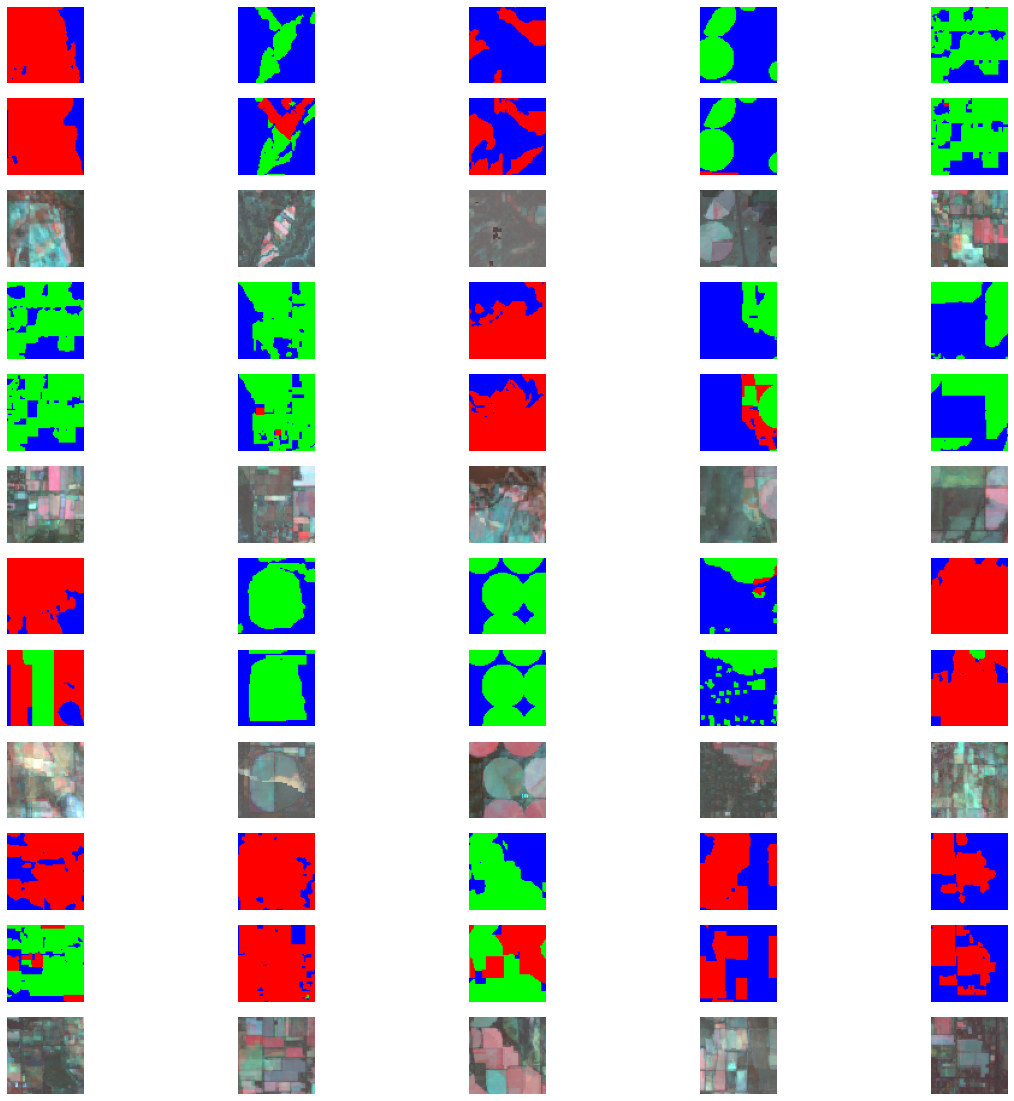

In [67]:
show_10_img()